In [1]:
!pip install yfinance --quiet

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

# Equity Mean Reversion Signal

In [5]:
# tickers = ['SPXL', 'TQQQ']
tickers = ['TQQQ']
weight = 0

param1 = 10
param2 = 1.0
param3 = 0.5

signal_dict = dict()

weights_df = pd.DataFrame(columns=tickers)

for ticker in tickers:
    df = yf.download(ticker, start='2025-1-1')

    df_ = df.xs(ticker, level=1, axis=1)
    df_.index = pd.to_datetime(df_.index)

    position = 0

    df_['HL_avg'] = df_['High'].rolling(window=param1).mean() - df_['Low'].rolling(window=param1).mean()
    df_['Band'] = df_['Close'].rolling(window=param1).mean() - (df_['HL_avg'] * param2)
    df_['IBS'] = ((df_['Close'] - df_['Low']) / (df_['High'] - df_['Low']))


    df_['Position'] = np.nan

    for i in np.arange(len(df_.index)):
        if i >= param1:
            if (df_['Close'][i] <= df_['Band'][i]) and (df_['IBS'][i] <= param3):

                position += 1
                df_['Position'][i] = position

            elif (position > 0) and (df_['Close'][i] >= df_['Close'][i-1]):

                position = 0
                df_['Position'][i] = position

            else:
                df_['Position'][i] = position

    weights_df[ticker] = df_['Position']

print('\n')
print(weights_df.iloc[-1])

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TQQQ']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


TypeError: Index must be a MultiIndex

<Axes: xlabel='Date'>

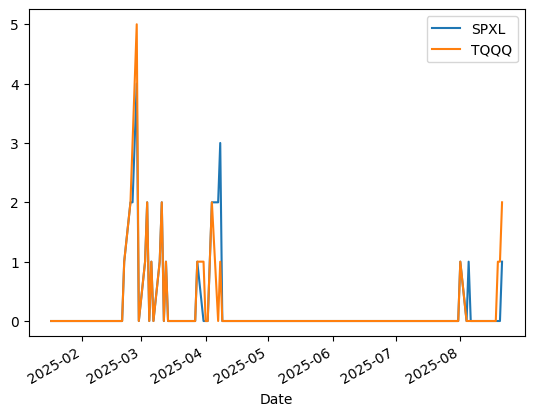

In [9]:
weights_df.plot()

VIX Tail-Risk Hedge Signal

In [10]:
tickers = ['^GSPC', '^VIX', '^VIX3M']
vc_df = yf.download(tickers, start='2025-1-1')['Close']
vc_df.ffill(inplace=True)
vc_df.columns = ['SPX', 'VIX', 'VIX3M']
vc_df.index = pd.to_datetime(vc_df.index)

RV = vc_df['SPX'].pct_change().rolling(2).std() * np.sqrt(252) * 100
VRP = vc_df['VIX'] - RV
VTS = vc_df['VIX3M'] / vc_df['VIX']

final_vc_df = pd.concat([vc_df['VIX'], VRP, VTS], axis=1, join='inner')
final_vc_df.columns = ['VIX', 'VRP', 'VTS']

final_vc_df['weight'] = np.where((final_vc_df['VRP'] < 0) & (final_vc_df['VTS'] < 1), final_vc_df['VIX'] / 100 * 1, 0)

print('\n')
print('VIX Tail-Risk Hedge Signal')
print(final_vc_df['weight'].iloc[-1])

[*********************100%***********************]  3 of 3 completed



VIX Tail-Risk Hedge Signal
0.0
